### Подготовка данных

In [1]:
from word2vec import Word2Vec
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from nltk.corpus import conll2000
from sklearn import preprocessing

In [2]:
stemmer = SnowballStemmer("english")
def normalize(raw_text):
    words = nltk.word_tokenize(raw_text)
    words = [word.lower() for word in words if word.isalpha()]
    # words = [stemmer.stem(word) for word in words]
    return words

In [3]:
f = open('./text_files/shelley-frankenstein-160.txt', "r")
documents = f.read().split('\n')
documents = [normalize(document) for document in documents]
print(documents[:2])

[['the', 'event', 'on', 'which', 'this', 'fiction', 'is', 'founded', 'has', 'been', 'supposed', 'by'], ['darwin', 'and', 'some', 'of', 'the', 'physiological', 'writers', 'of', 'germany', 'as', 'not']]


### Обучение

In [4]:
w2v = Word2Vec()
w2v.fit(documents)

Количество уникальных слов: 2860
cuda: False
SkipGramModel(
  (w_embeddings): Embedding(5719, 300, sparse=True)
  (v_embeddings): Embedding(5719, 300, sparse=True)
)


Обучение: 100%|███████████████████████████| 5058/5058 [00:37<00:00, 134.73it/s]


### Функции

In [5]:
w2v.get_emb('ift')
type(w2v.get_emb('may'))

Слова ift нет в словаре


numpy.ndarray

In [6]:
w2v.get_emb('ift')
w2v.get_similar('may', 2)

Слова ift нет в словаре


['will', 'shall']

### Визуализация

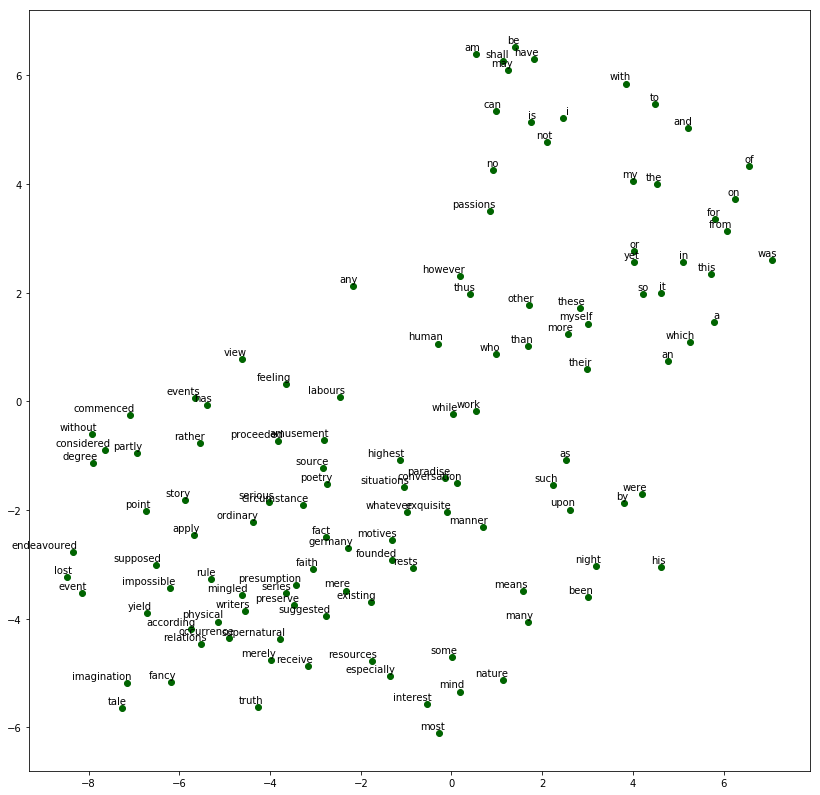

In [7]:
def plot_with_labels(low_dim_embs, labels):
    plt.figure(figsize=(14, 14))  
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y, c = 'darkgreen')
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

def embeddings_2d(embeddings):
    tsne = TSNE(n_components = 2, random_state = 42)
    embeddings_2d = tsne.fit_transform(embeddings)
    return embeddings_2d

num_words_to_draw = 120
embed = [w2v.get_emb(word) for word in w2v.get_words()]

a = plot_with_labels(embeddings_2d(embed[:num_words_to_draw]), w2v.get_words()[:num_words_to_draw])

### Тесты

#### Similarity

Для тестирования готовых эмбеддингов на схожесть слов воспользуемся готовым решением: https://github.com/EloiZ/embedding_evaluation/tree/master/data

Используются датасеты: MEN, WordSim-353, Verb-143.

In [8]:
from embedding_evaluation.evaluate import Evaluation

embedding_dict = {}
for i in range(len(embed)):
    embedding_dict[w2v.get_words()[i]] = embed[i]
    
embeddings = embedding_dict

evaluation = Evaluation() 

evaluation.evaluate(embeddings)

{'similarity': {'verb': {'all_entities': 0.06645129152480926,
   'entity_subset': 0,
   'total_pairs': 144,
   'used_pairs': 30},
  'ws353': {'all_entities': 0.5536036982818012,
   'entity_subset': 0,
   'total_pairs': 352,
   'used_pairs': 38},
  'men': {'all_entities': 0.22098620962247847,
   'entity_subset': 0,
   'total_pairs': 3000,
   'used_pairs': 391}}}

#### Pos Tagging

Сделаем классификацию на части речи с помощью готовых эмбеддингов на датасете conll2000.

In [9]:
all_words = conll2000.tagged_words('train.txt')

In [10]:
df = pd.DataFrame(all_words, columns = ['word', 'target'])
df['word'] = [word.lower() for word in df['word'].tolist()]
df = df[df['word'].isin(w2v.get_words())].drop_duplicates().sample(frac = 1.)
df_train = df.iloc[:1870].copy()
df_test = df.iloc[1870:].copy()
df_train['word'][:2].tolist(), df_test['word'][:2].tolist(), len(df_train), len(df_test)

(['germany', 'close'], ['writing', 'understood'], 1870, 991)

In [11]:
df_train['target'].value_counts()[:10]

NN     433
VB     214
VBN    194
NNP    181
JJ     175
VBD    154
VBP    115
NNS    114
RB      99
VBG     50
Name: target, dtype: int64

In [12]:
X_train = [w2v.get_emb(word.lower()) for word in df_train['word'].tolist()]
X_test = [w2v.get_emb(word.lower()) for word in df_test['word'].tolist()]

In [13]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'ovr', fit_intercept = False, tol = 1e-4, 
                           random_state = 42, max_iter = 400)
model.fit(X_train, df_train['target'])
y_pred = model.predict(X_test)
count_misclassified = (df_test['target'] != y_pred).sum()
print('Misclassified: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(df_test['target'], y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified: 766
Accuracy: 0.23


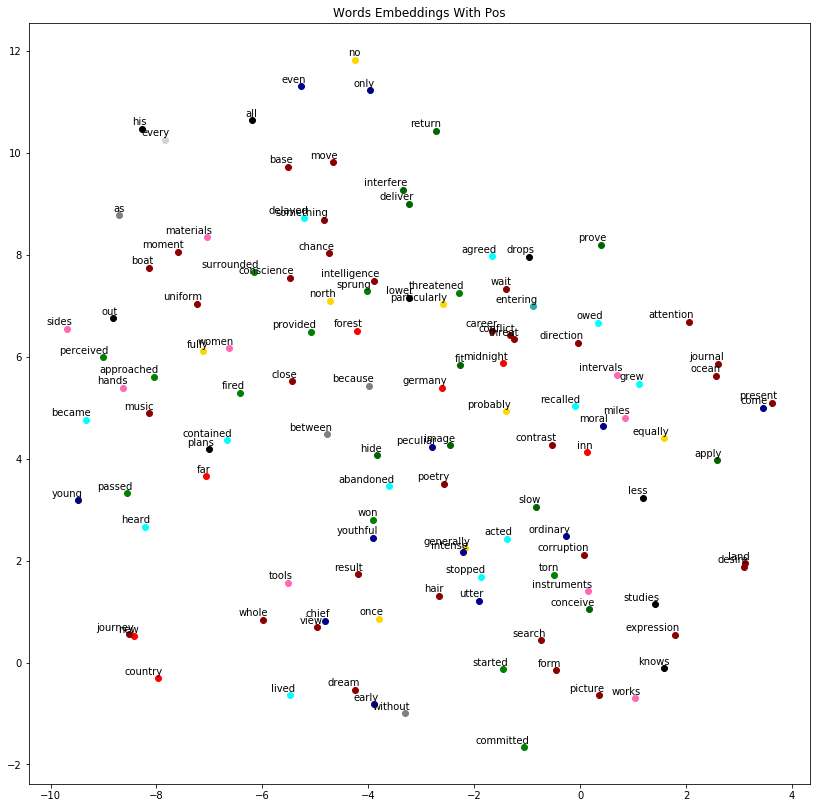

In [14]:
color_pallete = {'NN':'darkred', 'VB':'darkgreen', 'VBN':'green', 'NNP':'red', 
                 'VBD':'cyan', 'VBP':'limegreen', 'VBG':'lightseagreen', 'NNS':'hotpink', 
                 'JJ':'darkblue', 'RB':'gold', 'IN':'grey', 'DT':'lightgrey', 
                 'CC':'orange', 'TO':'brown', 'PRP':'blue', 'NNPS':'orchid'}
def plot_with_pos(low_dim_embs, labels, colors):
    plt.figure(figsize=(14, 14))
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        try:
            plt.scatter(x, y, c = color_pallete[str(colors[i])])
        except:
            plt.scatter(x, y, c = 'black')
        plt.title('Words Embeddings With Pos')
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

a = plot_with_pos(embeddings_2d(X_train[:120]), list(df_train['word'].iloc[:120]), list(df_train['target'].iloc[:120]))

In [15]:
train_words = conll2000.tagged_words('train.txt')
test_words = conll2000.tagged_words('test.txt')

In [16]:
df_train = pd.DataFrame(train_words, columns = ['word', 'target'])
df_test = pd.DataFrame(test_words, columns = ['word', 'target'])
df_train['word'] = [word.lower() for word in df_train['word'].tolist()]
df_test['word'] = [word.lower() for word in df_test['word'].tolist()]
df_train = df_train[df_train['word'].isin(w2v.get_words())]
df_test = df_test[df_test['word'].isin(w2v.get_words())]
df_train['word'][:2].tolist(), df_test['word'][:2].tolist(), len(df_train), len(df_test)

(['confidence', 'in'], ['said', 'it'], 104530, 22899)

In [17]:
X_train = [w2v.get_emb(word.lower()) for word in df_train['word'].tolist()]
X_test = [w2v.get_emb(word.lower()) for word in df_test['word'].tolist()]

In [18]:
model = LogisticRegression(solver = 'lbfgs', multi_class = 'ovr', fit_intercept = True, tol = 1e-3, 
                           random_state = 42, max_iter = 200)
model.fit(X_train, df_train['target'])
y_pred = model.predict(X_test)
count_misclassified = (df_test['target'] != y_pred).sum()
print('Misclassified: {}'.format(count_misclassified))
accuracy = metrics.accuracy_score(df_test['target'], y_pred)
print('Accuracy: {:.2f}'.format(accuracy))

Misclassified: 6574
Accuracy: 0.71


### Сохранение модели

In [19]:
w2v.save_state('./saved_models/myw2v.pth.tar')